<a href="https://colab.research.google.com/github/2714830587-xh/CLRS-GG/blob/master/1010-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tensor([0.8461, 0.1637, 0.9687, 0.0104])
tensor([0.9741, 0.1614, 0.0828, 0.9195])
counter= 10000
counter= 20000
0.7560840249061584
0.09440174698829651
tensor([0.4895, 0.5653, 0.4809, 0.3944], grad_fn=<SigmoidBackward0>)
counter= 10000
counter= 20000
用时间为 12.310730695724487
tensor([0.9038, 0.0515, 0.9294, 0.0441], grad_fn=<SigmoidBackward0>)


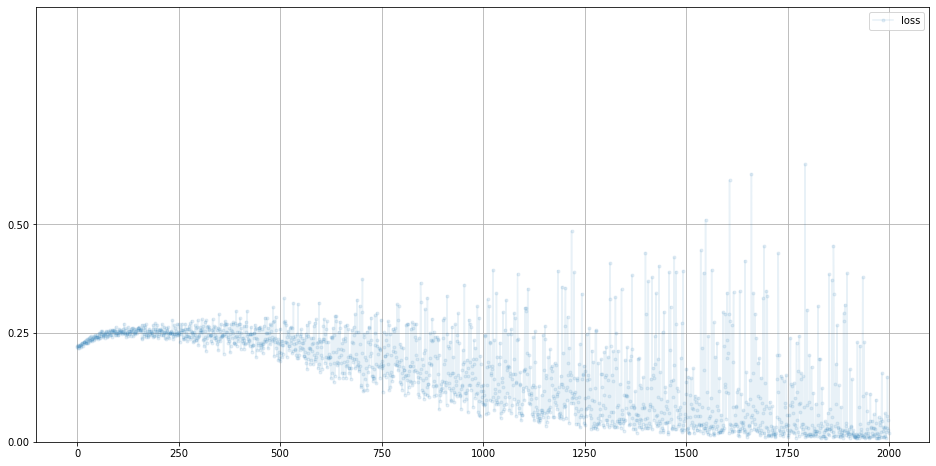

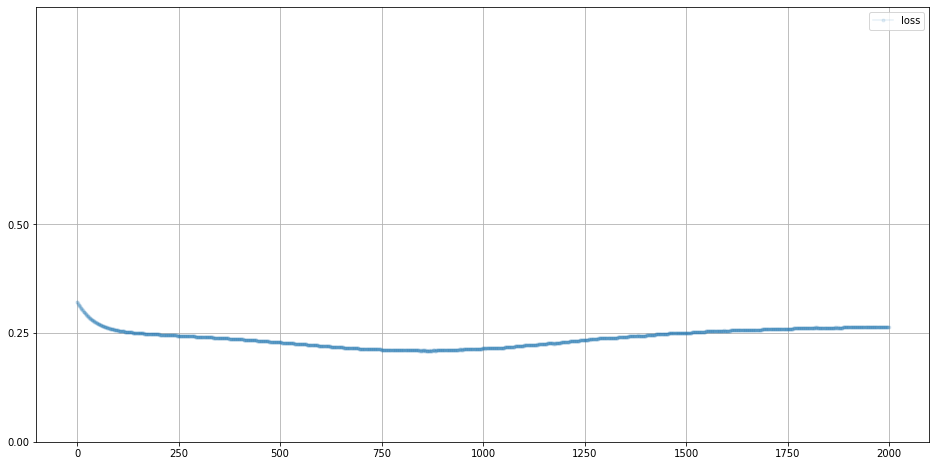

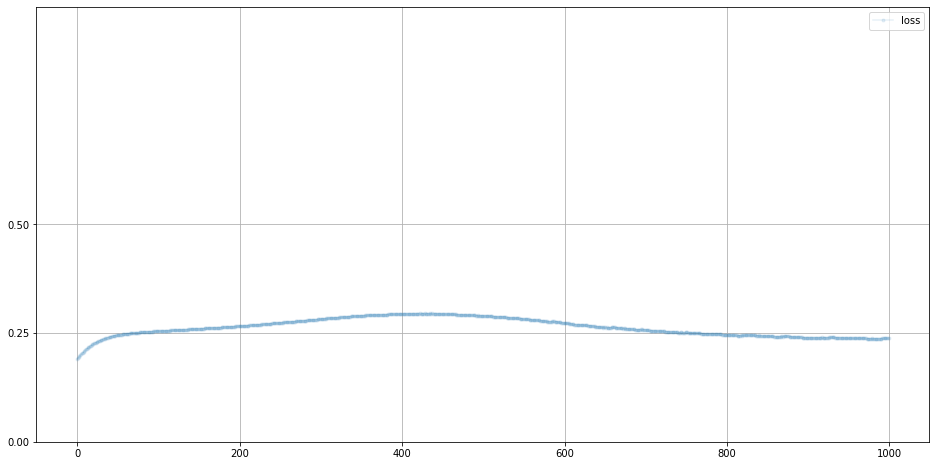

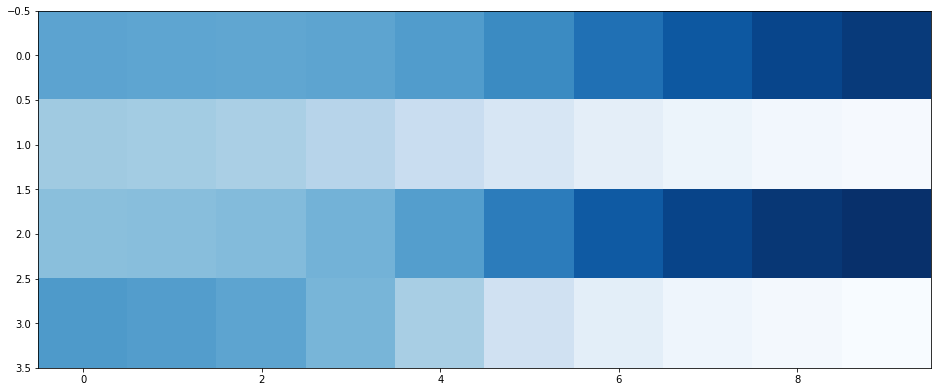

In [1]:
import random
import time
import torch
import torch.nn as nn
import pandas
import  matplotlib.pyplot as plt
import numpy
# 真实样本,生成类似与[1,0,1,0]tensor类型的随机数
def generate_real():
    real_data=torch.FloatTensor(
        [random.uniform(0.8,1.0),
         random.uniform(0.0,0.2),
         random.uniform(0.8,1.0),
         random.uniform(0.0,0.2)
         ])
    return real_data
# fake样本,生成
# 返回一个由区间上均匀分布的随机数填充的张量 [0, 1)张量的形状由变量参数 定义size

def generate_randrom(size):
    random_data=torch.rand(size)
    return  random_data
# x=random.uniform(0.0,0.2)
# print(x)
print(generate_real())
print(generate_randrom(4))
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 定义网络
        self.model=nn.Sequential(
            nn.Linear(4,3),
            nn.Sigmoid(),
            nn.Linear(3,1),
            nn.Sigmoid()
        )
        # 定义损失函数和优化器
        self.loss_function=nn.MSELoss()
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        # 勇于记录一个计数器和进程记录列表
        self.counter=0
        self.progress=[]
        pass
    def forward(self, inputs):
        return self.model(inputs)
    def train(self,inputs,targets):
        # 计算网络输出
        outputs=self.forward(inputs)


        #计算loss
        loss=self.loss_function(outputs,targets)
        # 增加计数器和积累错误没十次
        self.counter+=1;
        if(self.counter%10==0):
            self.progress.append(loss.item())
            pass
        if(self.counter%10000==0):
            print("counter=",self.counter)
            pass
        #反向传播和优化
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    def plot_progress(self):
        df=pandas.DataFrame(self.progress,columns=["loss"])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
# D的训练损失函数
D=Discriminator()
for i in range(10000):
    # real data
    D.train(generate_real(),torch.FloatTensor([1.0]))
    #fake data
    D.train(generate_randrom(4),torch.FloatTensor([0.0]))
D.plot_progress()


print(D.forward(generate_real()).item())
print(D.forward(generate_randrom(4)).item())

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model=nn.Sequential(
            nn.Linear(1,3),
            nn.Sigmoid(),
            nn.Linear(3,4),
            nn.Sigmoid()
        )
        # 没有损失函数有优化器
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        #     定义计数器和进程记录
        self.counter=0
        self.progress=[]
        pass


    def forward(self, inputs):
        outputs=self.model(inputs)
        return outputs

    def train(self,D,inputs,targets):
        # G的输出
        G_output=self.forward(inputs)
        #将G的输出通过D得到ouput,用来计算损失
        D_G_output=D.forward(G_output)
        loss=D.loss_function(D_G_output,targets)
        # 记录
        self.counter+=1
        if(self.counter%10==0):
            self.progress.append(loss.item())
            pass
        # if (self.counter % 10000 == 0):
        #     print("counter=", self.counter)
        #     pass
        # 梯度归零,反向传播,更新权重----思考更新是self.optimiser 而不是D.optimiser
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    def plot_progress(self):
        df=pandas.DataFrame(self.progress,columns=["loss"])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
G=Generator()
print(G.forward(torch.FloatTensor([0.8])))
# 创建G和D
start_time=time.time()
D=Discriminator()
G=Generator()
image_list = []
for i in range(10000):
    # 用真实样本训练D
    D.train(generate_real(),torch.FloatTensor([1.0]))
    # 用生成样本训练D
    # 注意detach-好处在于切断计算图的好处不是很明显。但是，对于更大的网络，这么做可以明显地节省计算成本。
    # 对于生成器输出，detach()的作用是将其从计算图中分离出来。
    D.train(G.forward(torch.FloatTensor([0.5])).detach(),torch.FloatTensor([0.0]))
    # 训练生成器
    G.train(D,torch.FloatTensor([0.5]),torch.FloatTensor([1.0]))
    # add image to list every 1000
    if (i % 1000 == 0):
      image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

    pass
# plot discriminator error

D.plot_progress()
# plot generator error

G.plot_progress()
# manually run generator to see it's outputs
end_time = time.time()
print("用时间为",end_time-start_time)
print(G.forward(torch.FloatTensor([0.5])))
# plot images collected during training

plt.figure(figsize = (16,8))

plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')
